In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json

%matplotlib inline

In [2]:
# quick dictionary extracted from the key, there are better ways to do this!
with open('Data/binary_to_ascii.json', 'r') as file:
    binary_to_ascii = json.load(file)


In [3]:
# function for showing results from processing
def show_results(images, titles=[], cols=2):
    count = len(images)
    rng = count if count % 2 == 0 else count + 1
    rows = int(round(rng/cols)) if int(round(rng/cols)) > 0 else 1
    img_w, img_h = images[0].shape[:2]
        
    fig, axs = plt.subplots(
        ncols=cols,
        nrows=rows,
        figsize=(20, (((20/cols)*img_w)/img_h)*rows),
        layout='tight'
    )
    current_row = 0
    current_col = 0
    for i in range(count):
        ax = axs[current_row, current_col] if rows > 1 else axs[current_col]
        ax.imshow(cv2.cvtColor(np.asarray(images[i]), cv2.COLOR_BGR2RGB))
        
        if titles:
            ax.title.set_text(titles[i])
        
        ax.set_xticks([])
        ax.set_yticks([])

        if rows > 1 and current_col == (cols - 1):
            current_row += 1
            current_col = 0
        else:
            current_col += 1
    
    plt.show()


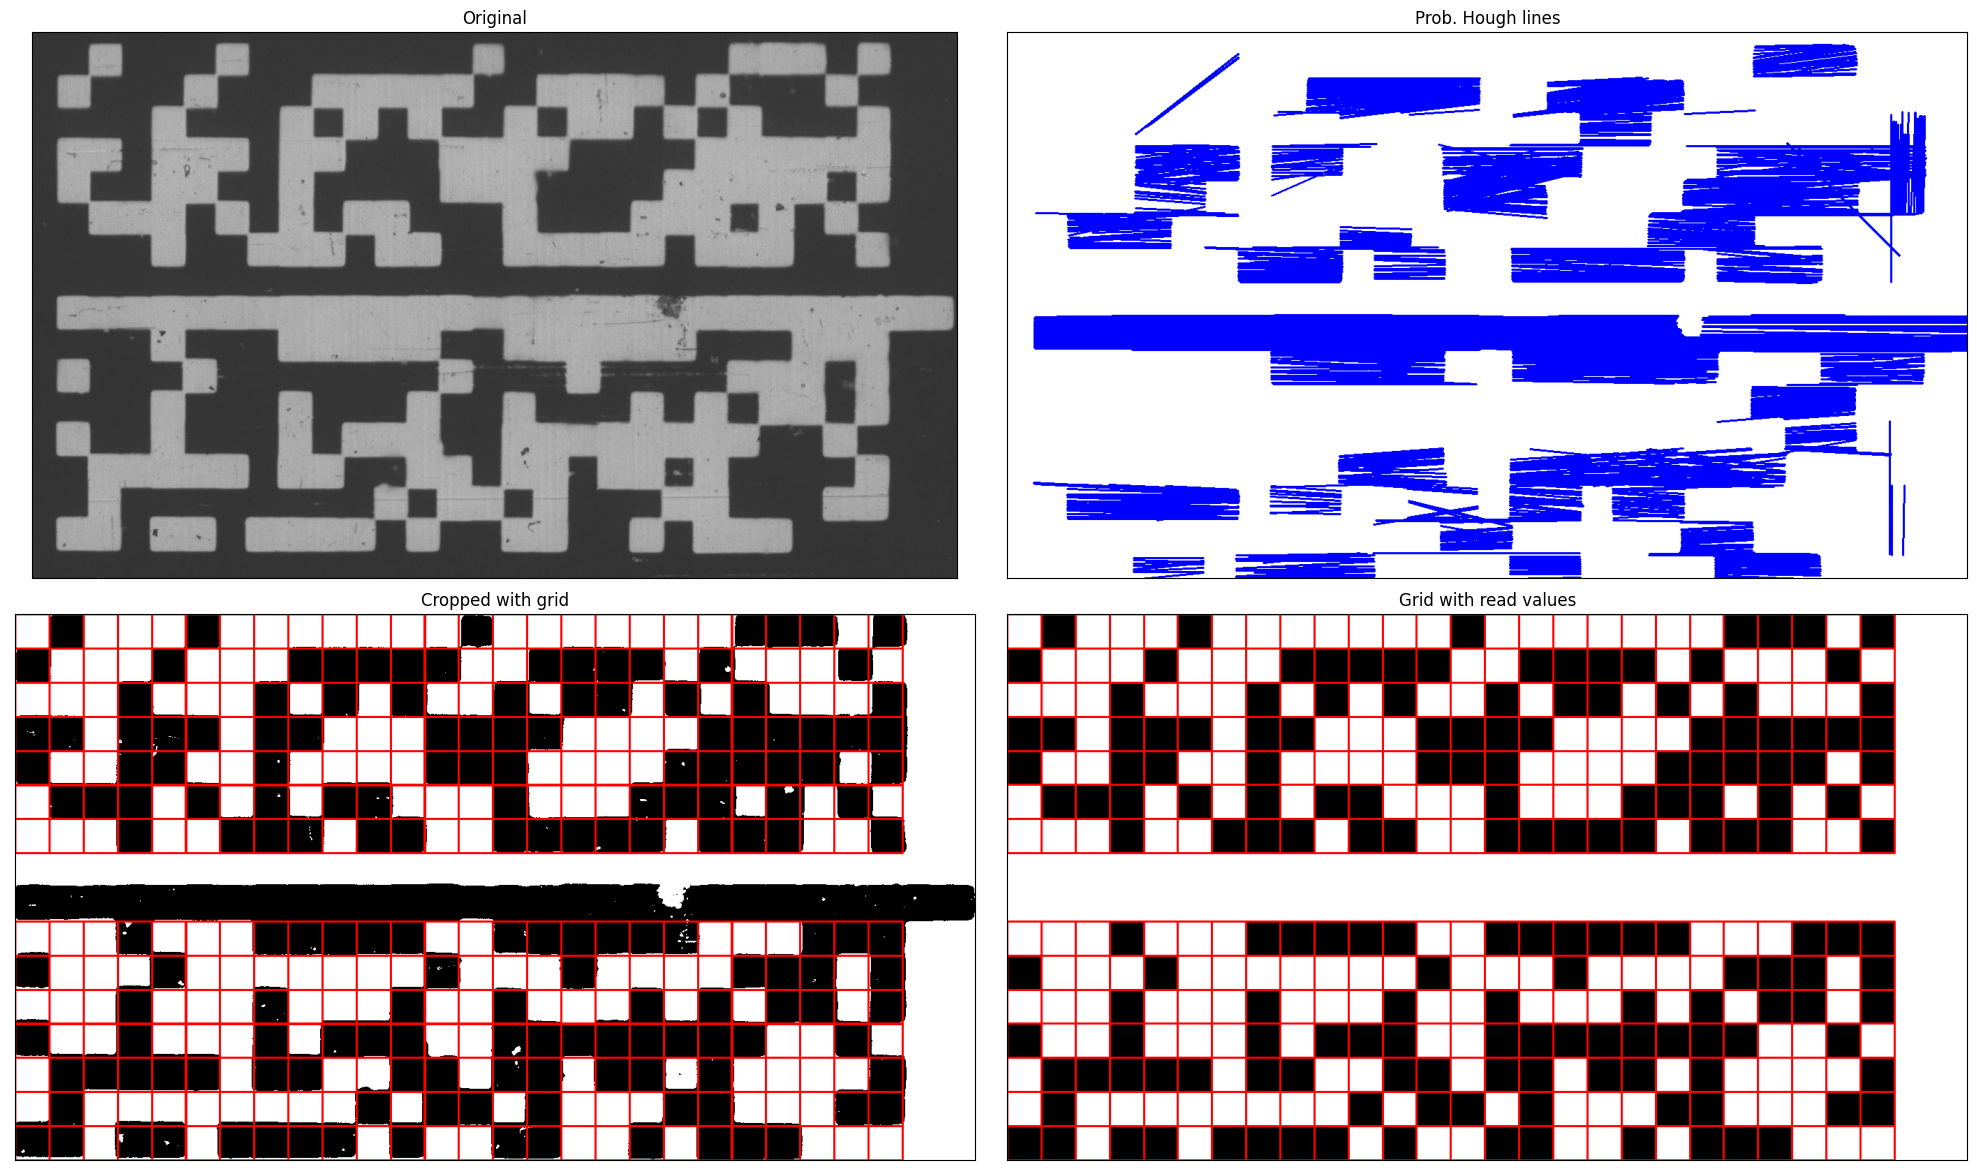

In [4]:
# load the image
image_path = 'Data/Baudot-Murray-example_cropped.jpg' # path to cropped code
image = cv2.imread(image_path) # read the image in
img_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # convert to greyscale
thresh, img_bin = cv2.threshold(img_grey, 127, 255, cv2.THRESH_BINARY_INV) # binarize

# now get probabilistic Hough lines
hlines = cv2.HoughLinesP(cv2.bitwise_not(img_bin), 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
# create a hull from them to get a contour around the content
c_hull = cv2.convexHull(np.array(hlines).reshape((-1, 1, 2)).astype(np.int32))
# use that contour's bounding rect to get the area of the code
x, y, w, h = cv2.boundingRect(c_hull)
# crop the image tightly 
img_cropped = img_bin[y:y + h, x:x + w]

# create a blank image of the same size to show results
img_h, img_w = img_cropped.shape[:2]
img_blank = np.zeros([img_h, img_w, 3], dtype=np.uint8)
img_blank.fill(255)

# plot Hough lines on a copy of the blank image
img_hlines = np.copy(img_blank)
for ln in hlines:
    x1, y1, x2, y2 = ln[0]
    cv2.line(img_hlines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# create copy of cropped image to plot grid
img_grid = cv2.cvtColor(img_cropped, cv2.COLOR_GRAY2RGB)

# we calculate the size of a grid cell
grid_side = img_h / 16
binary_code = [] # list to store binary values

# now we create the grid, measure the pixel values in the image, and store them as binary
for row in range(26): # the system has 26 rows
    top = round(row * grid_side)
    bottom = round(top + grid_side)
    row_values = []
    
    for col in range(16): # and 16 columns of which only 14 are used in two groups of 7
        if col == 7 or col == 8: # we skip the two separator columns 
            continue
        
        left = round(col * grid_side)
        right = round(left + grid_side)
        img_sample = img_cropped[left:right, top:bottom] # crop the image to the grid square
        value = 0 if np.average(img_sample) > 177 else 1 # and average the colour | split on 177 in 0-255 range
        row_values.append(value)
        # draw the grid and measured value (just for show)
        colour = (255, 255, 255) if value == 0 else (0, 0, 0)
        cv2.rectangle(img_blank, (top, left), (bottom, right), colour, cv2.FILLED)
        cv2.rectangle(img_blank, (top, left), (bottom, right), (0, 0, 255), 2)
        cv2.rectangle(img_grid, (top, left), (bottom, right), (0, 0, 255), 2)
    
    binary_code.append(row_values)
    row_values = []

show_results(
    [image, img_hlines, img_grid, img_blank],
    ['Original', 'Prob. Hough lines', 'Cropped with grid', 'Grid with read values']
)


In [5]:
# we split the code and flip it
code_section_1 = np.flip(np.array([l[:7] for l in binary_code]), axis=1)
code_section_2 = np.flip(np.array([l[7:] for l in binary_code]), axis=1)

# and show the results
for i, code in enumerate([code_section_1, code_section_2]):
    bin_values = [''.join([str(v) for v in line]) for line in list(code)]
    print(f'\nCODE SECTION {i + 1}:')
    for val in bin_values:
        print(f'{val}\t{binary_to_ascii.get(val, "UNKNOWN")}')



CODE SECTION 1:
0011010	/
0101001	D
0100000	space
1111100	tab
0011010	/
0101001	D
1000000	UNKNOWN
1111100	tab
1001010	N
0100110	C
1100010	UNKNOWN
1000110	L
0011010	/
0011001	UNKNOWN
1111100	tab
1001010	N
1000110	L
1000110	L
1100010	UNKNOWN
0110100	UNKNOWN
1111010	UNKNOWN
1011101	return
1111001	*
0011001	UNKNOWN
0101010	E
1011101	return

CODE SECTION 2:
1001010	N
1110000	Y
0010000	8
1011101	return
1010010	R
0010000	8
1000000	UNKNOWN
1011101	return
1010001	Q
1001001	M
0101001	D
1011101	return
0110010	I
0100000	space
1011101	return
1111001	*
0001011	5
0011001	UNKNOWN
1011101	return
0101001	D
1111100	tab
1001010	N
1000110	L
0000111	3
0101001	D
0110111	or
